In [1]:
import numpy as np
from scipy.misc import comb
from scipy.sparse import coo_matrix, find
from scipy.sparse.data import _data_matrix

from random import randint

In [2]:
labels_true = [randint(0,5000) for _ in range(100000)]
labels_pred = [randint(0,5000) for _ in range(100000)]

In [3]:
classes, class_idx = np.unique(labels_true, return_inverse=True)
clusters, cluster_idx = np.unique(labels_pred, return_inverse=True)
n_classes = classes.shape[0]
n_clusters = clusters.shape[0]

c = coo_matrix((np.ones(class_idx.shape[0]),(class_idx, cluster_idx)),
                             shape=(n_classes, n_clusters),
                             dtype=np.int)
c_array = c.toarray()
csr = c.tocsr()
csc = c.tocsc()

In [4]:
%timeit c.sum(axis=0)
%timeit c.sum(axis=1)
%timeit find(c)
%timeit c.tocsc().data.flatten()

1000 loops, best of 3: 528 µs per loop
10000 loops, best of 3: 176 µs per loop
100 loops, best of 3: 16.8 ms per loop
1000 loops, best of 3: 753 µs per loop


In [5]:
%timeit c_array.sum(axis=0)
%timeit c_array.sum(axis=1)
%timeit c_array.flatten()

10 loops, best of 3: 20.8 ms per loop
100 loops, best of 3: 16.1 ms per loop
10 loops, best of 3: 125 ms per loop


In [6]:
%timeit csr.sum(axis=0)
%timeit csr.sum(axis=1)
%timeit find(csr)
%timeit csr.data.flatten()

1000 loops, best of 3: 238 µs per loop
1000 loops, best of 3: 197 µs per loop
100 loops, best of 3: 11.7 ms per loop
10000 loops, best of 3: 45.9 µs per loop


In [7]:
%timeit csc.sum(axis=0)
%timeit csc.sum(axis=1)
%timeit find(csc)
%timeit csc.data.flatten()

10000 loops, best of 3: 199 µs per loop
10000 loops, best of 3: 168 µs per loop
100 loops, best of 3: 16.8 ms per loop
10000 loops, best of 3: 46.5 µs per loop


In [8]:
from sklearn import metrics
%timeit metrics.cluster.homogeneity_completeness_v_measure(labels_true, labels_pred, max_n_classes=10000)
%timeit metrics.cluster.homogeneity_completeness_v_measure(labels_true, labels_pred, max_n_classes=10000, sparse=True)

1 loop, best of 3: 488 ms per loop
10 loops, best of 3: 77.8 ms per loop


In [9]:
%timeit metrics.cluster.mutual_info_score(labels_true, labels_pred, contingency=c_array)
%timeit metrics.cluster.mutual_info_score(labels_true, labels_pred, contingency=c)
%timeit metrics.cluster.mutual_info_score(labels_true, labels_pred, contingency=csr)
%timeit metrics.cluster.mutual_info_score(labels_true, labels_pred, contingency=csc)

1 loop, best of 3: 349 ms per loop
10 loops, best of 3: 20.6 ms per loop
100 loops, best of 3: 15.4 ms per loop
10 loops, best of 3: 20.4 ms per loop


In [10]:
from scipy import misc
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering, mean_shift
from sklearn.externals import joblib
face = misc.face(gray=True)
face = misc.imresize(face, 0.20) / 255.
graph = image.img_to_graph(face)
beta = 5
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps
spec_cluster = joblib.Memory('/tmp/bench_cache').cache(spectral_clustering)
ward_cluster = joblib.Memory('/tmp/bench_cache').cache()


n_clusters_vals = [5, 10, 20, 50, 100, 250]
labellings = {}


for random_offset in [0, 1]:
    for n_clusters in n_clusters_vals:
        labels = spec_cluster(graph, n_clusters=n_clusters,
                              assign_labels='kmeans',
                              random_state=random_offset + n_clusters)
        labellings[random_offset, n_clusters] = labels


________________________________________________________________________________
[Memory] Calling sklearn.cluster.spectral.spectral_clustering...
spectral_clustering(<31212x31212 sparse matrix of type '<type 'numpy.float64'>'
	with 155346 stored elements in COOrdinate format>, random_state=11, assign_labels='kmeans', n_clusters=10)
_____________________________________________spectral_clustering - 99.3s, 1.7min


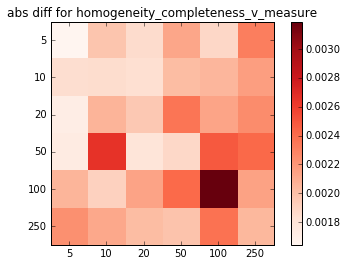

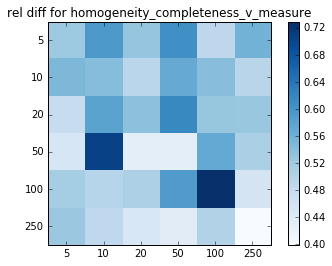

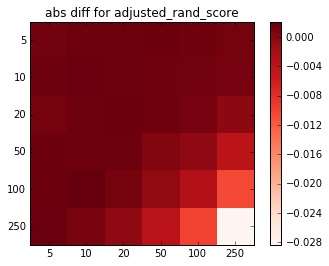

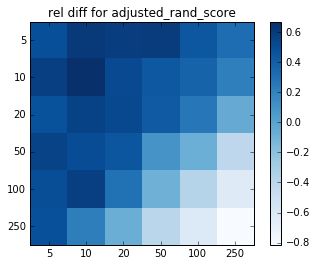

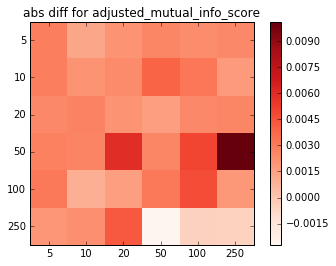

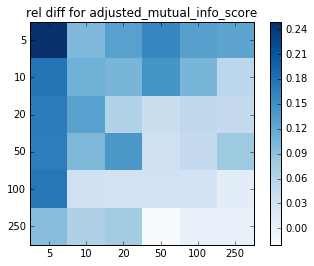

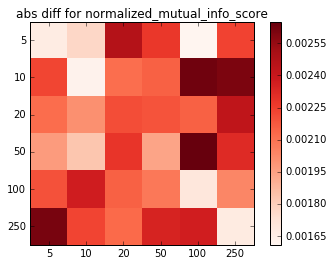

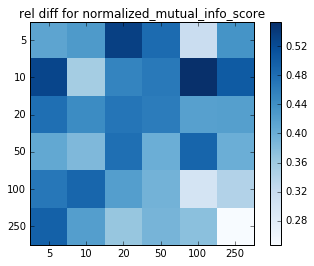

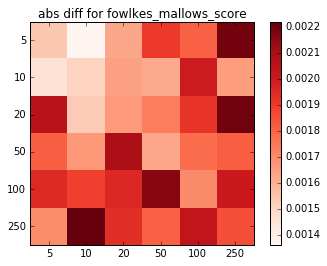

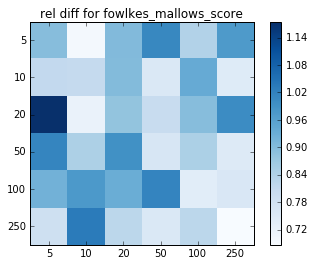

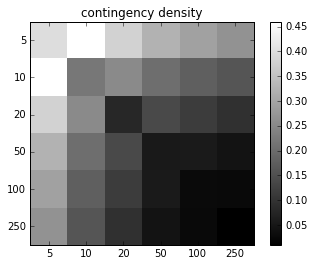

In [23]:
from collections import defaultdict
import numpy as np
import timeit
import pprint
from sklearn import metrics
from matplotlib import pyplot as plt
trials = 10
for metric in [metrics.cluster.homogeneity_completeness_v_measure,
               metrics.cluster.adjusted_rand_score,
               metrics.cluster.adjusted_mutual_info_score,
               metrics.cluster.normalized_mutual_info_score,
               metrics.cluster.fowlkes_mallows_score]:
    results = defaultdict(list)
    for (random_offset1, n_clusters1), labels1 in labellings.items():
        for (random_offset2, n_clusters2), labels2 in labellings.items():
            if random_offset1 == random_offset2 and n_clusters1 == n_clusters2:
                continue
            dense_res = timeit.timeit(lambda: metric(labels1, labels2, sparse=False), number=trials)
            sparse_res = timeit.timeit(lambda: metric(labels1, labels2, sparse=True), number=trials)
            results[n_clusters1, n_clusters2].append([(sparse_res - dense_res) / trials, (sparse_res - dense_res) / dense_res,
                                                      metrics.cluster.contingency_matrix(labels1, labels2, sparse=True).nnz / float(n_clusters1 * n_clusters2)])
    keys, vals = zip(*sorted(results.items()))
    n_n_clusters = len(n_clusters_vals)
    vals = np.array([np.mean(v, axis=0) for v in vals]).reshape(n_n_clusters, n_n_clusters, 3)
    abs_diffs = vals[..., 0]
    rel_diffs = vals[..., 1]
    densities = vals[..., 2]
    
    def plot(data, cmap, title):
        plt.figure()
        plt.imshow(data, cmap=cmap, interpolation='nearest')
        plt.xticks(range(n_n_clusters), n_clusters_vals)
        plt.yticks(range(n_n_clusters), n_clusters_vals)
        plt.title(title)
        plt.colorbar()
        plt.show()

    plot(abs_diffs, 'Reds', 'abs diff for %s' % metric.__name__)
    plot(rel_diffs, 'Blues', 'rel diff for %s' % metric.__name__)

plot(densities, 'gray', 'contingency density')
